In [39]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../preprocessing/Artifact_Removal/Batch_ArtifactFilter_Epoch.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
import os
import seaborn as sns
import mne
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

from sklearn import preprocessing
from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.
ERROR:tornado.application:Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x000001BE270100D0>)
Traceback (most recent call last):
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\ipykernel\kernelbase.py", line 306, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [4]:
path = 'D:\stim_code_epochs'
epoch_files = os.listdir(path)

In [5]:
np.random.seed(42)
n = np.random.randint(0,len(epoch_files))
print(n)

102


In [6]:
epoch = mne.read_epochs(os.path.join(path, epoch_files[6]), preload = True)

Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [7]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [8]:
# reduce dimensions of n_times to a point for each band.
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-8-20254dd9ff05>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage);


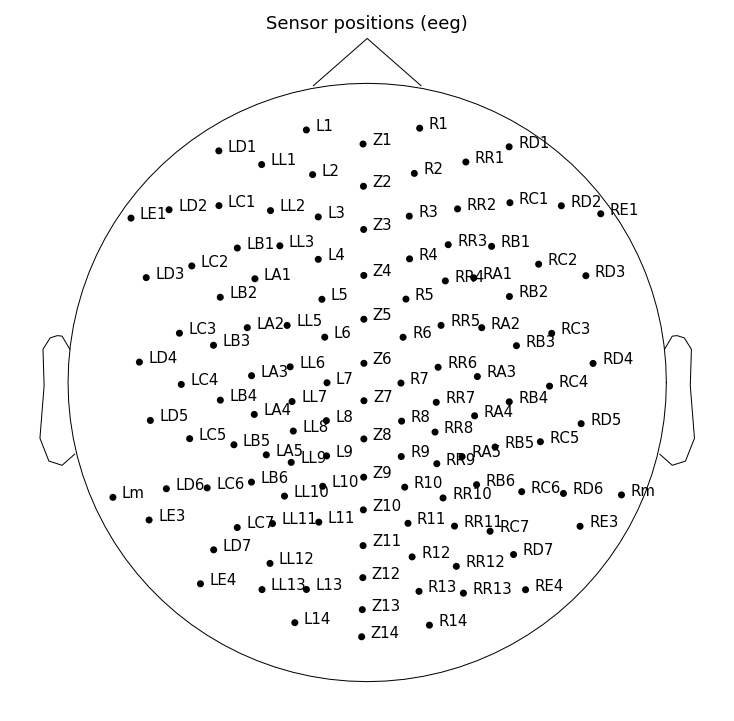

In [9]:
epoch.plot_sensors(show_names=True);

In [ ]:

frequency_map = list()
frequency_data = list()
for band, fmin, fmax in iter_freqs:
    epoch = mne.read_epochs(os.path.join(path, epoch_files[n]), preload = True)
    epoch.drop_channels(['Nasium','Lm','Rm','VEOG'])
    filtered_epoch = epoch.filter(fmin, fmax, n_jobs=1,
                                    l_trans_bandwidth = 1,
                                    h_trans_bandwidth = 1,
                                    fir_design = 'firwin')
    filtered_epoch.subtract_evoked()
    filtered_epoch = mne.EpochsArray(filtered_epoch.get_data(), info = filtered_epoch.info,
                                      tmin = filtered_epoch.tmin, events = filtered_epoch.events)
    frequency_map.append(((band,fmin,fmax), filtered_epoch.average()))
    frequency_data.append(((band,fmin,fmax), filtered_epoch))
    

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [ ]:
gamma_epoch = frequency_data[- 1][-1]

In [ ]:
# classify using gamma data and theta data because it has the most spikes
epoch_trials = get_epoch_trials(gamma_epoch)
# convert_event_ids_to_stim_combinations(gamma_epoch,trial_index_list, stim_combinations)
np.array(epoch_trials[0])[:,-1]

In [ ]:
new_events = convert_epoch_events_to_stim_combinations(epoch_object = gamma_epoch)
# new_events[:100]

In [ ]:
trial = np.array(epoch_trials[0])
trial[:,-1] = 1
trial

In [12]:
data = epoch.get_data()

In [13]:
new_events = convert_epoch_events_to_stim_combinations(epoch)

In [14]:
epoch.events = new_events

In [22]:
# create arrays based on audio and visual
audio_epochs = []
visual_epochs = []

for i in range(len(epoch)): 
#     print(i)
    if epoch[i].events[:,-1][0] <700:
#         print("audio")
        audio_epochs.append(epoch[i].get_data())
    else:
#         print("visual")
        visual_epochs.append(epoch[i].get_data())

In [23]:
pipeline = make_pipeline(Vectorizer(), StandardScaler())
scaled_audio_data = pipeline.fit_transform(audio_epochs)
scaled_visual_data = pipeline.fit_transform(visual_epochs)

In [90]:
vectorizer = make_pipeline(Vectorizer())
vectorized_audio_data = vectorizer.fit_transform(audio_epochs)
vectorized_visual_data = vectorizer.fit_transform(visual_epochs)


In [91]:
scaled_audio_data = preprocessing.scale(vectorized_audio_data)
scaled_visual_data = preprocessing.scale(vectorized_visual_data)

C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\preprocessing\data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\preprocessing\data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [28]:
audio_variance = []
for data in scaled_audio_data:
#     print(data)
    audio_variance.append(np.var(data))
visual_variance = []
for data in scaled_visual_data:
    visual_variance.append(np.var(data))

In [ ]:
all_variance = []


In [42]:
np.array(visual_variance)

array([0.66393401, 0.46730791, 0.44800439, 3.14626716, 2.77410205,
       1.13016472, 0.64192582, 0.51754316, 3.04438652, 1.49389974,
       1.00852666, 1.8456873 , 0.70113947, 0.74267201, 1.47803803,
       0.93031192, 1.09456939, 0.93698425, 0.55870688, 0.65826538,
       0.66921686, 0.58324123, 0.51301683, 0.48993534, 0.64328735,
       0.67974857, 0.89108094, 0.8960154 , 0.53733354, 0.51472107,
       0.82782925, 0.77434569, 0.95277801, 0.60992002, 0.6665384 ,
       0.84209552, 0.77550277, 0.56233965, 1.24086166, 0.77147014,
       0.63942345, 0.70328572, 0.66325526, 0.57118768, 0.81720081,
       0.88941643, 0.91838935, 1.39603972, 0.82875111, 0.75704981,
       0.6909227 , 0.75202772, 1.34288349, 0.98758512, 0.53719372,
       4.15703725, 2.62066623, 2.09730757, 6.02044279, 0.67846985,
       1.05798292, 0.43547993, 0.51829803, 0.46740193, 0.57954233,
       0.67000292, 0.73594938, 0.68032806, 0.84005769, 0.56518955,
       0.57676788, 0.74010998, 0.52475618, 0.76622247, 0.66721

In [36]:
np.array(audio_variance).shape

(474,)

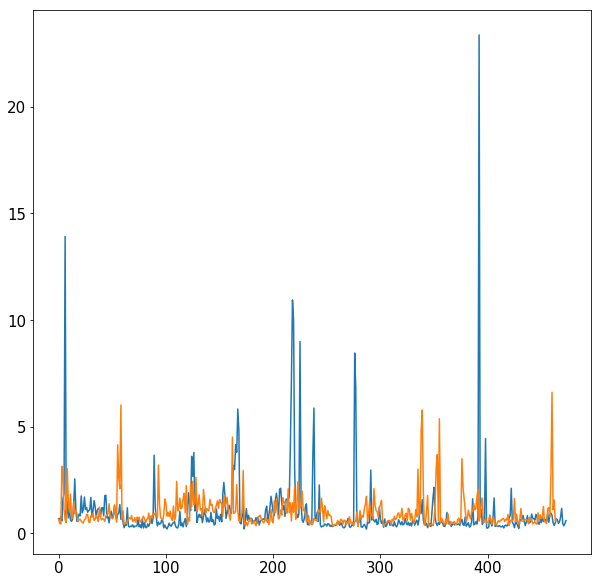

In [44]:
plt.plot(audio_variance)
plt.plot(visual_variance)